# Dense networks on CIFAR10

In this lab you will see how well neural networks with fully connected layers perform on a dataset with more complex images. For example, CIFAR10 images have RGB values and thus each pixel corresponds to three values.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import time

In [2]:
# Choose which device to use
use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

### Load the dataset

In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform)

batch_size = 128
w, h, c = 32, 32, 3  # Width, Height, Nr. of channels for the input images (RGB)
k = 10  # Number of output classes

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]

170500096it [00:03, 43420625.48it/s]                               


Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar
Files already downloaded and verified


### Show image examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
torch.Size([128, 3, 32, 32])


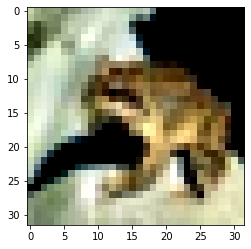

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


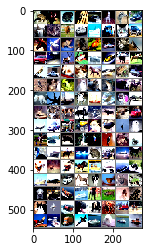

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images[0].shape)
print(images.shape)

# show images
imshow(images[0])
imshow(torchvision.utils.make_grid(images))

### Exercise - Defining an architecture

In this lab we will use fully connected neural networks. Create a dense neural network class that has a variable number of layers and layer sizes.

In [ ]:
class MLP(nn.Module):

  def __init__(self,
               input_size,  # Size of the input. Here we will first flatten the image to a single vector with the 3 * 32 * 32 values in the image 
               layer_sizes,  # A tuple containing the sizes of the hidden layers of the neural network. So to create a NN with two hidden layers with 32 neurons in each layer you'd set layer_sizes=(32,32)
               output_size):  # The size of the network output. CIFAR10 has 10 output classes
    super(MLP, self).__init__()
    shape = (input_size,) + tuple(layer_sizes) + (output_size,)
    self.layers = nn.ModuleList([nn.Linear(shape[i], shape[i + 1]) for i in range(len(shape) - 1)])  # Store the layers in a ModuleList object so they are recognized by pytorch as submodules of this model

  def forward(self, x):
    for layer in self.layers[:-1]:  # Apply relu activation to all but the last layer in the network
      x = F.relu(layer(x))
    return self.layers[-1](x)


In [10]:
model = MLP(w * h * c, (128, 128), k).to(device)  # Create a new dense neural network with two hidden layers of size 128

print(model)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Train the network

Finish the code below so the network is trained on the images. The network should be able to reach an accuracy of about 50%. This is much better than taking random guesses, so the network did learn something. However, it is not a great classifier either. Dense neural networks are usually not the way to go for image classification. Instead, Convolutional Neural Networks are often used. These will be covered in the next lecture.

In [11]:
start=time.time()

criterion = nn.CrossEntropyLoss()

lr = 0.01
momentum = 0.5
num_epochs = 20

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, num_epochs + 1):
  # Iterate through the entire train set
  for i, (x_batch, y_batch) in enumerate(trainloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    optimizer.zero_grad()  # Set all currenly stored gradients to zero 

    y_pred = model(x_batch.view(-1, w * h * c))

    loss = criterion(y_pred, y_batch)

    loss.backward()

    optimizer.step()

    # Compute relevant metrics
        
    y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

    correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

    elapsed = time.time() - start  # Keep track of how much time has elapsed

    # Show progress every 20 batches 
    if not i % 20:
      print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')
    
  # Evaluate the model on the test set
  correct_total = 0
  for i, (x_batch, y_batch) in enumerate(testloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    y_pred = model(x_batch.view(-1, w * h * c))
    y_pred_max = torch.argmax(y_pred, dim=1)

    correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

  print(f'Test accuracy: {correct_total / len(testset.data):.3f}')



epoch: 1, time: 0.028s, loss: 2.285, train accuracy: 0.148
epoch: 1, time: 0.400s, loss: 2.208, train accuracy: 0.234
epoch: 1, time: 0.743s, loss: 2.203, train accuracy: 0.188
epoch: 1, time: 1.100s, loss: 2.143, train accuracy: 0.188
epoch: 1, time: 1.456s, loss: 2.008, train accuracy: 0.297
epoch: 1, time: 1.801s, loss: 1.972, train accuracy: 0.375
epoch: 1, time: 2.152s, loss: 1.956, train accuracy: 0.297
epoch: 1, time: 2.516s, loss: 1.854, train accuracy: 0.336
epoch: 1, time: 2.860s, loss: 1.887, train accuracy: 0.367
epoch: 1, time: 3.207s, loss: 1.929, train accuracy: 0.328
epoch: 1, time: 3.573s, loss: 1.795, train accuracy: 0.344
epoch: 1, time: 3.917s, loss: 1.943, train accuracy: 0.383
epoch: 1, time: 4.307s, loss: 1.806, train accuracy: 0.383
epoch: 1, time: 4.671s, loss: 1.845, train accuracy: 0.367
epoch: 1, time: 5.015s, loss: 1.822, train accuracy: 0.297
epoch: 1, time: 5.385s, loss: 1.809, train accuracy: 0.391
epoch: 1, time: 5.770s, loss: 1.686, train accuracy: 0.4